# 📊 Phase 4: Model Development

This notebook trains machine learning models for stock price prediction:
- **XGBoost** - Gradient boosting for tabular data
- **Random Forest** - Ensemble of decision trees
- **LSTM** - Deep learning for sequence prediction

## Prerequisites
- Complete Phase 2 (Feature Engineering) first
- Or use the downloaded S&P 500 data directly

In [1]:
!pip install xgboost tensorflow ipywidgets


[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# Core libraries
import pandas as pd
import numpy as np
import os
import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning - Preprocessing
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Machine Learning - Models
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

# Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Display settings
pd.set_option('display.max_columns', None)

print("All libraries imported successfully!")
print(f"TensorFlow version: {tf.__version__}")
print(f"XGBoost version: {xgb.__version__}")

All libraries imported successfully!
TensorFlow version: 2.20.0
XGBoost version: 3.1.3


## 1. Load Data

We'll load the S&P 500 stock data that was downloaded.

In [3]:
# Load sample stock data (using AAPL, MSFT, GOOGL for demo)
print("=" * 60)
print("LOADING STOCK DATA")
print("=" * 60)

data_path = '../data/raw/daily/sp500/'

# Select a few stocks for training demo
STOCKS = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META']
data_dict = {}

for ticker in STOCKS:
    filename = f'{data_path}{ticker}.csv'
    
    if os.path.exists(filename):
        df = pd.read_csv(filename, index_col=0, parse_dates=True)
        data_dict[ticker] = df
        print(f"Loaded {ticker}: {df.shape[0]} rows, {df.shape[1]} columns")
    else:
        print(f"File not found: {filename}")

print(f"\nSuccessfully loaded {len(data_dict)} stocks")

LOADING STOCK DATA
Loaded AAPL: 1509 rows, 5 columns
Loaded MSFT: 1509 rows, 5 columns
Loaded GOOGL: 1509 rows, 5 columns
Loaded AMZN: 1509 rows, 5 columns
Loaded META: 1509 rows, 5 columns

Successfully loaded 5 stocks


## 2. Feature Engineering

Add technical indicators for model training.

In [4]:
import ta

def add_features(df):
    """Add technical indicators as features"""
    data = df.copy()
    
    # Price features
    data['Returns'] = data['Close'].pct_change()
    data['Log_Returns'] = np.log(data['Close'] / data['Close'].shift(1))
    
    # Moving Averages
    data['SMA_20'] = ta.trend.sma_indicator(data['Close'], window=20)
    data['SMA_50'] = ta.trend.sma_indicator(data['Close'], window=50)
    data['EMA_12'] = ta.trend.ema_indicator(data['Close'], window=12)
    
    # RSI
    data['RSI'] = ta.momentum.rsi(data['Close'], window=14)
    
    # MACD
    macd = ta.trend.MACD(data['Close'])
    data['MACD'] = macd.macd()
    data['MACD_Signal'] = macd.macd_signal()
    
    # Bollinger Bands
    bollinger = ta.volatility.BollingerBands(data['Close'])
    data['BB_High'] = bollinger.bollinger_hband()
    data['BB_Low'] = bollinger.bollinger_lband()
    
    # ATR
    data['ATR'] = ta.volatility.average_true_range(data['High'], data['Low'], data['Close'])
    
    # Target: Next day return
    data['Target'] = data['Close'].shift(-1) / data['Close'] - 1
    
    return data.dropna()

# Apply features to first stock (AAPL)
stock = 'AAPL'
df = add_features(data_dict[stock])
print(f"Features added to {stock}: {df.shape[1]} columns")
print(f"Data range: {df.index.min()} to {df.index.max()}")
print(f"Total samples: {len(df)}")

Features added to AAPL: 17 columns
Data range: 2019-03-14 00:00:00 to 2024-12-27 00:00:00
Total samples: 1459


## 3. Prepare Train/Test Split

In [5]:
# Select features
feature_cols = ['Returns', 'SMA_20', 'SMA_50', 'EMA_12', 'RSI', 'MACD', 'MACD_Signal', 'BB_High', 'BB_Low', 'ATR']
target_col = 'Target'

X = df[feature_cols].values
y = df[target_col].values

# Time series split (80% train, 20% test)
split_idx = int(len(X) * 0.8)
X_train, X_test = X[:split_idx], X[split_idx:]
y_train, y_test = y[:split_idx], y[split_idx:]

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Training samples: {len(X_train)}")
print(f"Testing samples: {len(X_test)}")
print(f"Features: {len(feature_cols)}")

Training samples: 1167
Testing samples: 292
Features: 10


## 4. Train XGBoost Model

In [6]:
print("=" * 60)
print("TRAINING XGBOOST MODEL")
print("=" * 60)

# Create and train XGBoost model
xgb_model = xgb.XGBRegressor(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    verbosity=0
)

xgb_model.fit(X_train_scaled, y_train)

# Predictions
xgb_pred_train = xgb_model.predict(X_train_scaled)
xgb_pred_test = xgb_model.predict(X_test_scaled)

# Metrics
xgb_train_rmse = np.sqrt(mean_squared_error(y_train, xgb_pred_train))
xgb_test_rmse = np.sqrt(mean_squared_error(y_test, xgb_pred_test))
xgb_test_mae = mean_absolute_error(y_test, xgb_pred_test)
xgb_test_r2 = r2_score(y_test, xgb_pred_test)

print(f"\nXGBoost Results:")
print(f"  Train RMSE: {xgb_train_rmse:.6f}")
print(f"  Test RMSE:  {xgb_test_rmse:.6f}")
print(f"  Test MAE:   {xgb_test_mae:.6f}")
print(f"  Test R2:    {xgb_test_r2:.4f}")

TRAINING XGBOOST MODEL

XGBoost Results:
  Train RMSE: 0.010977
  Test RMSE:  0.022935
  Test MAE:   0.018201
  Test R2:    -1.7986


## 5. Train Random Forest Model

In [7]:
print("=" * 60)
print("TRAINING RANDOM FOREST MODEL")
print("=" * 60)

# Create and train Random Forest model
rf_model = RandomForestRegressor(
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    random_state=42,
    n_jobs=-1
)

rf_model.fit(X_train_scaled, y_train)

# Predictions
rf_pred_train = rf_model.predict(X_train_scaled)
rf_pred_test = rf_model.predict(X_test_scaled)

# Metrics
rf_train_rmse = np.sqrt(mean_squared_error(y_train, rf_pred_train))
rf_test_rmse = np.sqrt(mean_squared_error(y_test, rf_pred_test))
rf_test_mae = mean_absolute_error(y_test, rf_pred_test)
rf_test_r2 = r2_score(y_test, rf_pred_test)

print(f"\nRandom Forest Results:")
print(f"  Train RMSE: {rf_train_rmse:.6f}")
print(f"  Test RMSE:  {rf_test_rmse:.6f}")
print(f"  Test MAE:   {rf_test_mae:.6f}")
print(f"  Test R2:    {rf_test_r2:.4f}")

TRAINING RANDOM FOREST MODEL

Random Forest Results:
  Train RMSE: 0.015803
  Test RMSE:  0.021218
  Test MAE:   0.016030
  Test R2:    -1.3952


## 6. Train LSTM Model

In [8]:
print("=" * 60)
print("TRAINING LSTM MODEL")
print("=" * 60)

# Create sequences for LSTM
def create_sequences(X, y, seq_length=30):
    X_seq, y_seq = [], []
    for i in range(seq_length, len(X)):
        X_seq.append(X[i-seq_length:i])
        y_seq.append(y[i])
    return np.array(X_seq), np.array(y_seq)

SEQ_LENGTH = 30
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train, SEQ_LENGTH)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test, SEQ_LENGTH)

print(f"LSTM Training shape: {X_train_seq.shape}")
print(f"LSTM Testing shape: {X_test_seq.shape}")

# Build LSTM model
lstm_model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(SEQ_LENGTH, len(feature_cols))),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25, activation='relu'),
    Dense(1)
])

lstm_model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Callbacks
early_stop = EarlyStopping(patience=10, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(patience=5, factor=0.5, verbose=1)

# Train
history = lstm_model.fit(
    X_train_seq, y_train_seq,
    epochs=50,
    batch_size=32,
    validation_split=0.1,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

# Predictions
lstm_pred_test = lstm_model.predict(X_test_seq, verbose=0).flatten()

# Metrics
lstm_test_rmse = np.sqrt(mean_squared_error(y_test_seq, lstm_pred_test))
lstm_test_mae = mean_absolute_error(y_test_seq, lstm_pred_test)
lstm_test_r2 = r2_score(y_test_seq, lstm_pred_test)

print(f"\nLSTM Results:")
print(f"  Test RMSE:  {lstm_test_rmse:.6f}")
print(f"  Test MAE:   {lstm_test_mae:.6f}")
print(f"  Test R2:    {lstm_test_r2:.4f}")

TRAINING LSTM MODEL
LSTM Training shape: (1137, 30, 10)
LSTM Testing shape: (262, 30, 10)
Epoch 1/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - loss: 0.0031 - mae: 0.0418 - val_loss: 4.3297e-04 - val_mae: 0.0168 - learning_rate: 0.0010
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 9.6682e-04 - mae: 0.0231 - val_loss: 2.1038e-04 - val_mae: 0.0111 - learning_rate: 0.0010
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 6.3109e-04 - mae: 0.0186 - val_loss: 1.6564e-04 - val_mae: 0.0099 - learning_rate: 0.0010
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.4261e-04 - mae: 0.0171 - val_loss: 1.4820e-04 - val_mae: 0.0091 - learning_rate: 0.0010
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 5.1179e-04 - mae: 0.0164 - val_loss: 1.4579e-04 - val_mae: 0.0095 - learning_rate: 0.0010
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 4.9650e-04 - mae: 0.0162 - val_loss: 1.4349e-04 - val_mae: 0.0093 - learning_rate: 0.0010
Epoch 7/50
32/32 ━━━

## 7. Model Comparison

In [9]:
print("=" * 60)
print("MODEL COMPARISON")
print("=" * 60)

results = pd.DataFrame({
    'Model': ['XGBoost', 'Random Forest', 'LSTM'],
    'Test RMSE': [xgb_test_rmse, rf_test_rmse, lstm_test_rmse],
    'Test MAE': [xgb_test_mae, rf_test_mae, lstm_test_mae],
    'Test R2': [xgb_test_r2, rf_test_r2, lstm_test_r2]
})

results = results.sort_values('Test RMSE')
print("\n" + results.to_string(index=False))

best_model = results.iloc[0]['Model']
print(f"\nBest Model: {best_model}")

MODEL COMPARISON

        Model  Test RMSE  Test MAE   Test R2
         LSTM   0.014320  0.010570 -0.042335
Random Forest   0.021218  0.016030 -1.395242
      XGBoost   0.022935  0.018201 -1.798634

Best Model: LSTM


## 8. Feature Importance (XGBoost)

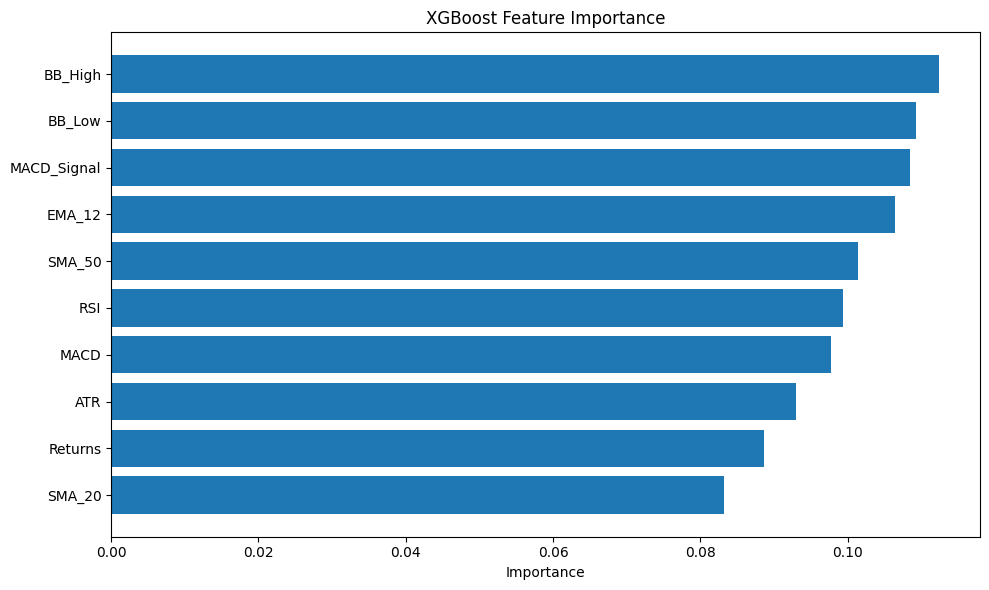


Top 5 Features:
    Feature  Importance
     SMA_50    0.101477
     EMA_12    0.106486
MACD_Signal    0.108504
     BB_Low    0.109229
    BB_High    0.112361


In [10]:
# Plot feature importance
importance = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': xgb_model.feature_importances_
}).sort_values('Importance', ascending=True)

plt.figure(figsize=(10, 6))
plt.barh(importance['Feature'], importance['Importance'])
plt.xlabel('Importance')
plt.title('XGBoost Feature Importance')
plt.tight_layout()
plt.show()

print("\nTop 5 Features:")
print(importance.tail(5).to_string(index=False))

## 9. Save Models

In [11]:
import joblib
import os

# Create directories
os.makedirs('../models/saved_models/xgboost', exist_ok=True)
os.makedirs('../models/saved_models/random_forest', exist_ok=True)
os.makedirs('../models/saved_models/lstm', exist_ok=True)
os.makedirs('../models/scalers', exist_ok=True)

# Save models
xgb_model.save_model('../models/saved_models/xgboost/xgboost_model.json')
joblib.dump(rf_model, '../models/saved_models/random_forest/rf_model.pkl')
lstm_model.save('../models/saved_models/lstm/lstm_model.keras')

# Save scaler
joblib.dump(scaler, '../models/scalers/feature_scaler.pkl')

print("Models saved successfully!")
print(f"  - XGBoost: models/saved_models/xgboost/xgboost_model.json")
print(f"  - Random Forest: models/saved_models/random_forest/rf_model.pkl")
print(f"  - LSTM: models/saved_models/lstm/lstm_model.keras")
print(f"  - Scaler: models/scalers/feature_scaler.pkl")

Models saved successfully!
  - XGBoost: models/saved_models/xgboost/xgboost_model.json
  - Random Forest: models/saved_models/random_forest/rf_model.pkl
  - LSTM: models/saved_models/lstm/lstm_model.keras
  - Scaler: models/scalers/feature_scaler.pkl


## Summary

In this notebook, we:
1. Loaded stock price data for AAPL
2. Added technical indicators as features
3. Trained three models: XGBoost, Random Forest, LSTM
4. Compared model performance
5. Analyzed feature importance
6. Saved models for deployment

**Next Steps:**
- Train on more stocks for a multi-asset model
- Tune hyperparameters with Optuna
- Use the trained models in the dashboard